# 한글 깨질 때 

https://velog.io/@redgreen/Linux-linux%EC%97%90%EC%84%9C-Matplotlib-%ED%95%9C%EA%B8%80%ED%8F%B0%ED%8A%B8-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0

In [2]:
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothicCoding')
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
import torch
import pandas as pd
import matplotlib.cm as cm
import matplotlib.patches as patches

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert")
model = AutoModelForSequenceClassification.from_pretrained("snunlp/KR-FinBert-SC")

/home/alpaco/anaconda3/envs/moon_mys/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


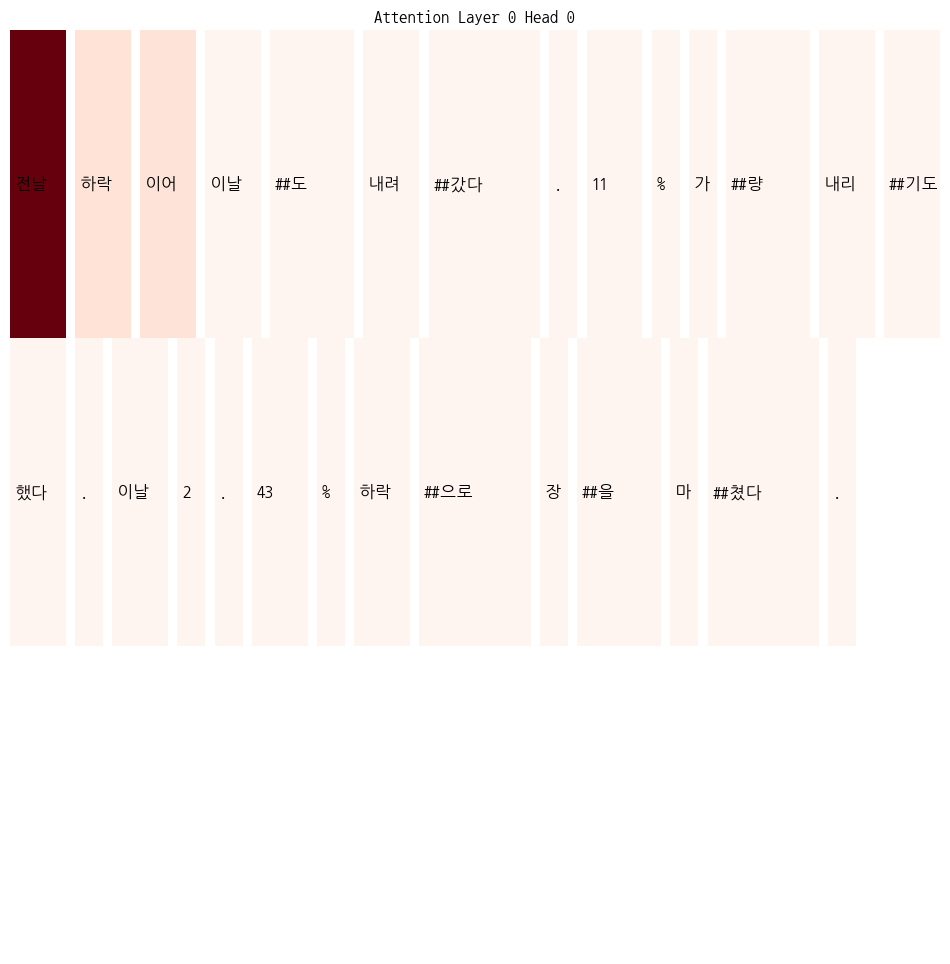

In [7]:
# 어텐션 스코어 추출 함수
def extract_attention_scores(texts, tokenizer, model, max_len=256):
    # 모델을 평가 모드로 전환
    model.eval()
    # 어텐션 스코어를 저장할 빈 리스트 초기화
    attention_scores = []
    for text in texts:
        # 입력 텍스트를 토크나이저로 인코딩하고, 최대 길이로 패딩 및 자르기
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")
        # 입력 텐서를 모델과 동일한 디바이스로 옮김
        encoding = {key: val.to(model.device) for key, val in encoding.items()}
        # 모델에 입력을 넣고 출력을 얻음. output_attentions=True로 어텐션 스코어도 함께 출력
        with torch.no_grad():
            outputs = model(**encoding, output_attentions=True)
        # 각 레이어의 어텐션 스코어를 attention_scores 리스트에 추가
        attentions = outputs.attentions
        attention_scores.append(attentions)
    return attention_scores

# 어텐션 스코어 시각화 함수
def plot_attention_with_text(attention_scores, tokenizer, text, layer=0, head=0):
    # 선택한 레이어와 헤드의 어텐션 스코어를 추출하고 NumPy 배열로 변환
    attn_weights = attention_scores[0][layer][0][head].cpu().numpy()
    # 입력 텍스트를 토큰으로 변환
    tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text, add_special_tokens=False))
    # 어텐션 스코어를 0~1 사이로 정규화
    attn_weights = attn_weights / attn_weights.max()
    # 시각화를 위한 Figure와 Axis 생성
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.axis('off')
    x = 0
    y = 1
    for i, token in enumerate(tokens):
        # 어텐션 스코어에 따라 색상을 결정
        color = cm.Reds(attn_weights[i, i])
        # 토큰 위에 색상 박스를 그림
        rect = patches.Rectangle((x, y), len(token) * 0.6, 1, linewidth=1, edgecolor='none', facecolor=color)
        ax.add_patch(rect)
        # 토큰 텍스트를 박스 위에 표시
        plt.text(x+0.1, y+0.5, token, fontsize=12, verticalalignment='center', color='black')
        # x 좌표를 토큰 길이만큼 이동
        x += len(token) * 0.6 + 0.2
        # x 좌표가 20을 넘어가면 다음 줄로 내려감
        if x > 20:
            x = 0
            y -= 1
    # x, y 축 범위를 설정
    plt.xlim(0, 20)
    plt.ylim(y-1, 2)
    # 제목 표시
    plt.title(f'Attention Layer {layer} Head {head}')
    # 시각화 결과 출력
    plt.show()

# news_summary.csv 파일에서 0, 1, 2, 3, 4 열을 읽어옴
news_df = pd.read_csv('./datas/news_summary.csv', usecols=[0,1,2,3,4])

# news_df의 'summ_context' 열에서 첫 번째 텍스트를 가져옴
# example_texts = list(news_df['summ_context'][:1])
# example_texts = '전날 상승 이어 이날도 올라갔다. 11%가량 오르기도 했다. 이날 2.43% 상승으로 장을 마쳤다.'
example_texts = '전날 하락 이어 이날도 내려갔다. 11%가량 내리기도 했다. 이날 2.43% 하락으로 장을 마쳤다.'
# 예제 텍스트에 대한 어텐션 스코어를 추출
attention_scores = extract_attention_scores(example_texts, tokenizer, model)

# 추출한 어텐션 스코어를 사용하여 시각화
# plot_attention_with_text(attention_scores, tokenizer, example_texts[0], layer=0, head=0)
plot_attention_with_text(attention_scores, tokenizer, example_texts, layer=0, head=0)
